# Analysis of ocean heat content monthly maps created from sparse observations

### >>> Please note files and code in the following were created for educational purposes and are not meant to be used for a research project. <<<

## Learning goals

- Identify differences in statistical methods based on the output ocean heat content field
- Visualize fields of intrest with uncertainties using conditional simulations 

Examples of possible fields to visualize are: maps of the trend, correlation with a time series of interest, running averages of regional ocean heat content time series, extreme events, lag-1 autocorrelation, maps of spatial derivatives, ... Feel free to explore fields that are of interest to you!

### Set up

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
dir_input = "./data/"

tag_datasets            = [1,2,3,4]
tag_method_with_CondSim = 3;
cols                    = ['b', 'g', 'r', 'gold']

In [3]:
# area weighted regional mean starting from an xarray
def xarray_regional_mean(dxr, form='area'):
    # given an xarray dataset <dxr> with latitudes and longitudes as dimensions,
    # calculate the area average of all data variables, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.LATITUDE))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    if form =='area':
        return dxr_weighted.mean(("LONGITUDE", "LATITUDE"))
    elif form == 'meridional':
        return dxr_weighted.mean(("LATITUDE"))
    elif form == 'zonal':
        return dxr_weighted.mean(("LONGITUDE"))

In [4]:
# remove the time mean
def remove_time_mean(x):
    return x - x.mean(dim='TIME')
    

In [5]:
# https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims=['TIME'], deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

### Load data

In this section, we use xarray to load the data and make some plots. For more information about how to use xarray, please visit https://tutorial.xarray.dev/intro.html

In [6]:
# store data from different statistical models in a dictionary
ds = {}
for i in tag_datasets:
    ds['dataset'+str(i)] = xr.open_dataset(dir_input+"dataset"+str(i)+".nc")

In [7]:
# load the conditional simulations for dataset tag_method_with_CondSim
ds_CondSim = {}
ds_CondSim['dataset'+str(tag_method_with_CondSim)] = xr.open_dataset(dir_input+"CondSim/dataset"+str(tag_method_with_CondSim)+'_CondSim.nc')
    


In [8]:
ds.keys()


dict_keys(['dataset1', 'dataset2', 'dataset3', 'dataset4'])

In [9]:
ds_CondSim['dataset3']

<xarray.Dataset> Size: 98MB
Dimensions:    (LONGITUDE: 81, LATITUDE: 66, TIME: 228, record: 10)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 648B 299.5 300.5 301.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float64 528B -65.5 -64.5 -63.5 ... -2.5 -1.5 -0.5
  * TIME       (TIME) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2022-12-15
Dimensions without coordinates: record
Data variables:
    DATA       (record, TIME, LATITUDE, LONGITUDE) float64 98MB ...
Attributes:
    history:  Wed Jun 12 23:15:21 2024: ncecat dataset3_001.nc dataset3_002.n...
    NCO:      netCDF Operators version 5.1.6 (Homepage = http://nco.sf.net, C...

## Question #1: Based on the plots in the following (and other plots you may decide to create), associate each of the datasets (1 to 4) to the correct mapping method (see description of mapping methods in the following; methods are listed in random order). It may be helpful to refer to your notes from the morning lectures.

Method A: SpaceTrend

Method B: SpaceTimeNoTrend

Method C: SpaceNoTrend

Method D: SpaceTimeTrend


### Example plots

We start with showing the domain of the fields provided, plotting the map for one timestep.

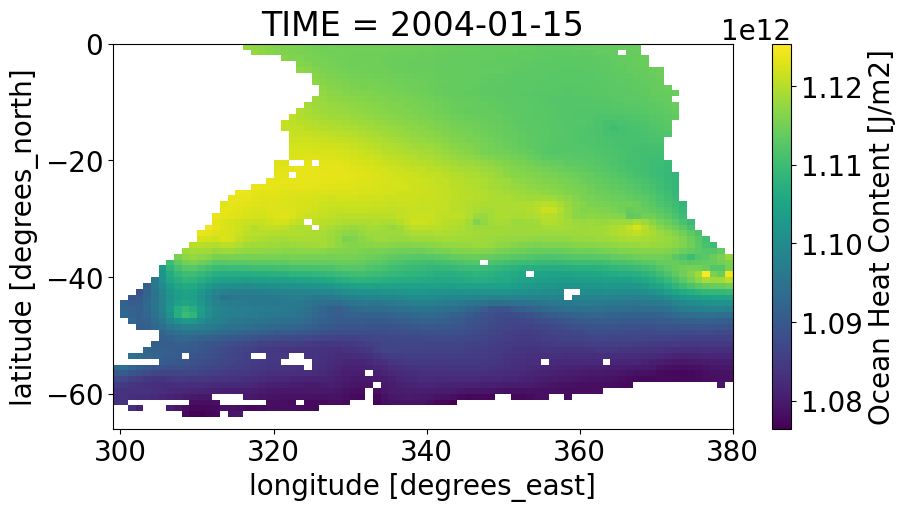

In [10]:
plt.figure(figsize=(10, 5))
plt.rc('font', size=20)

ds['dataset1'].DATA[0,:,:].plot()


We now show the timeseries of the area average in the domain.

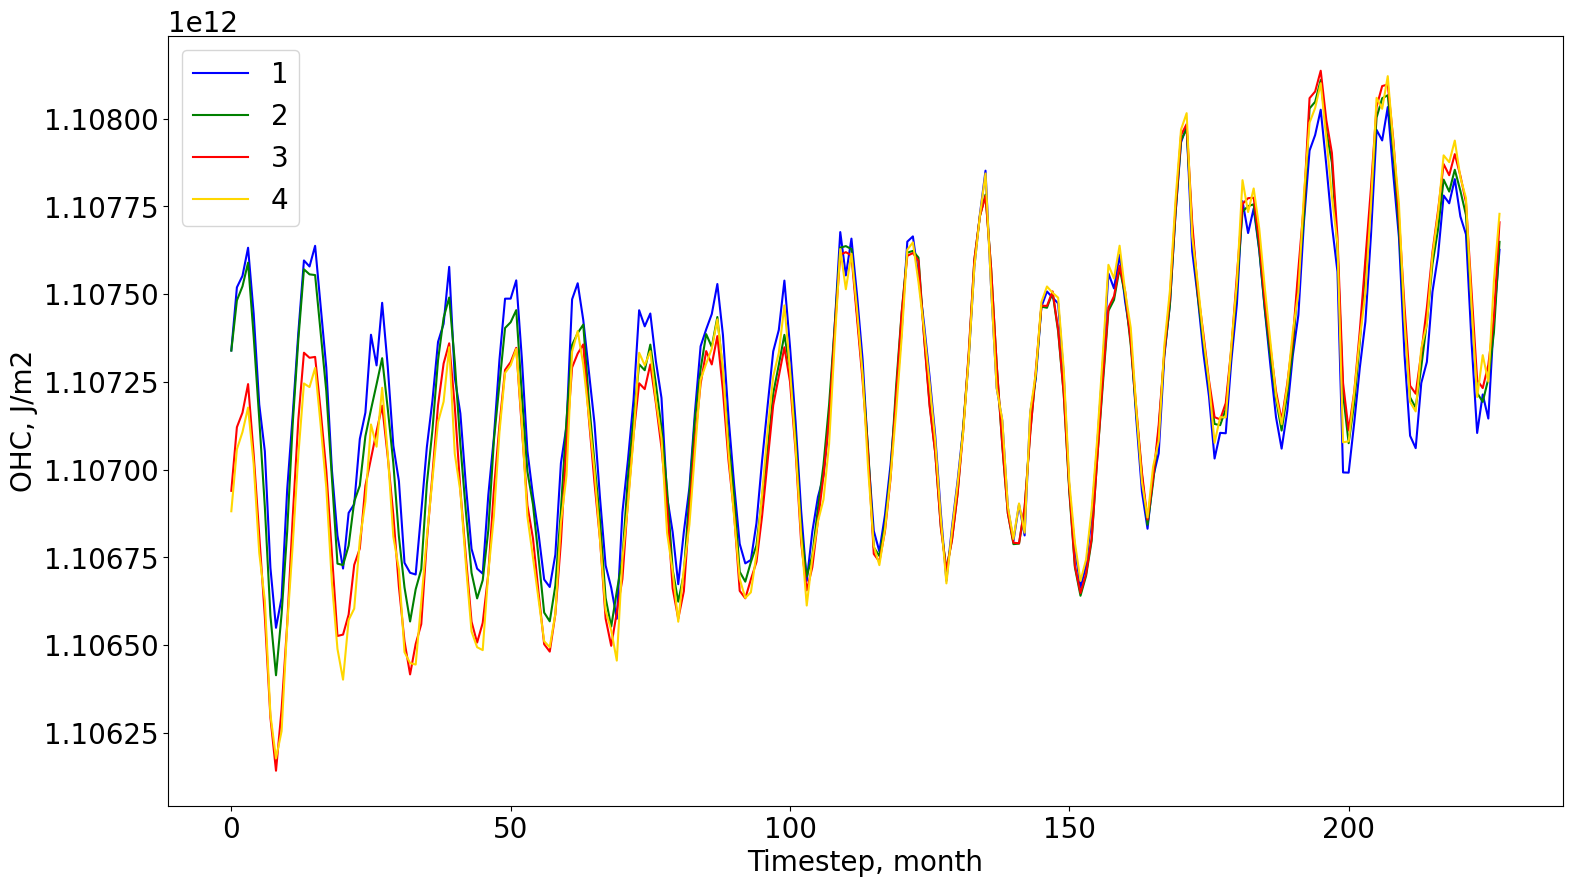

In [11]:
# plot the timeseries of the area average
plt.figure(figsize=(18, 10))
plt.rc('font', size=20)

for i,i_ds in enumerate(ds.keys()):
    d_1d = xarray_regional_mean(ds[i_ds], form='area')
    plt.plot(d_1d['DATA'].values,color=cols[i])
plt.legend(tag_datasets)
plt.xlabel('Timestep, month')
plt.ylabel('OHC, J/m2')
plt.show()

We then show the timeseries of the area average in the domain, after removing the seasonal cycle.

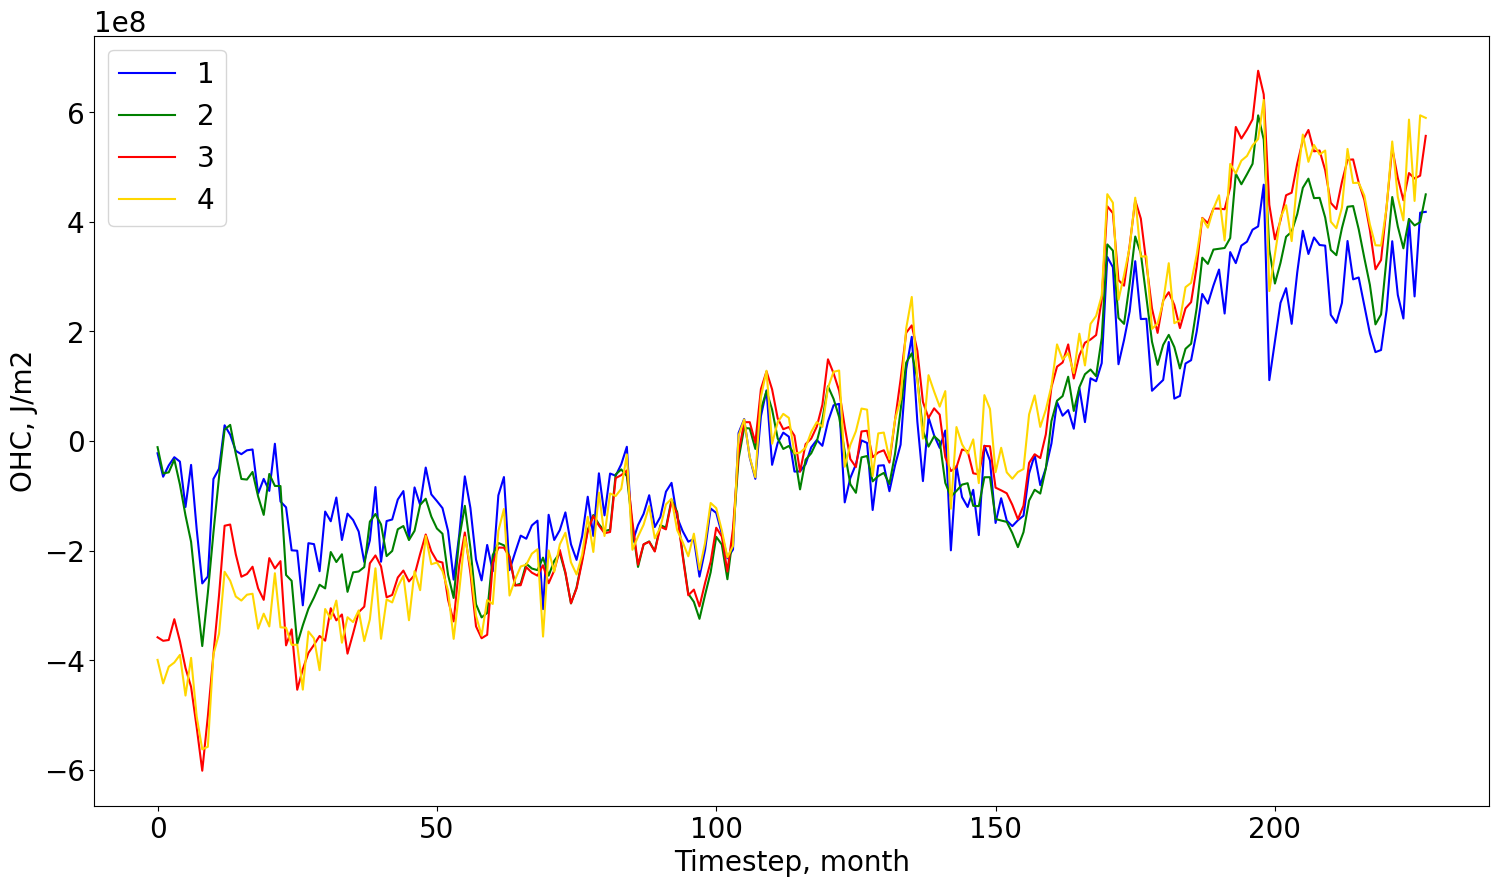

In [12]:
# plot the anomalies, i.e. after removing the seasonal cycle
plt.figure(figsize=(18, 10))
plt.rc('font', size=20)

for i,i_ds in enumerate(ds.keys()):
    d_1d = xarray_regional_mean(ds[i_ds], form='area').DATA.groupby('TIME.month').apply(remove_time_mean)
    plt.plot(d_1d,color=cols[i])
plt.legend(tag_datasets)
plt.xlabel('Timestep, month')
plt.ylabel('OHC, J/m2')
plt.show()

Finally, we show the timeseries of the area average in the domain, after removing the seasonal cycle and trend. For method #4, we also show +/1 the standard deviation of the estimate based on the conditional simulations.

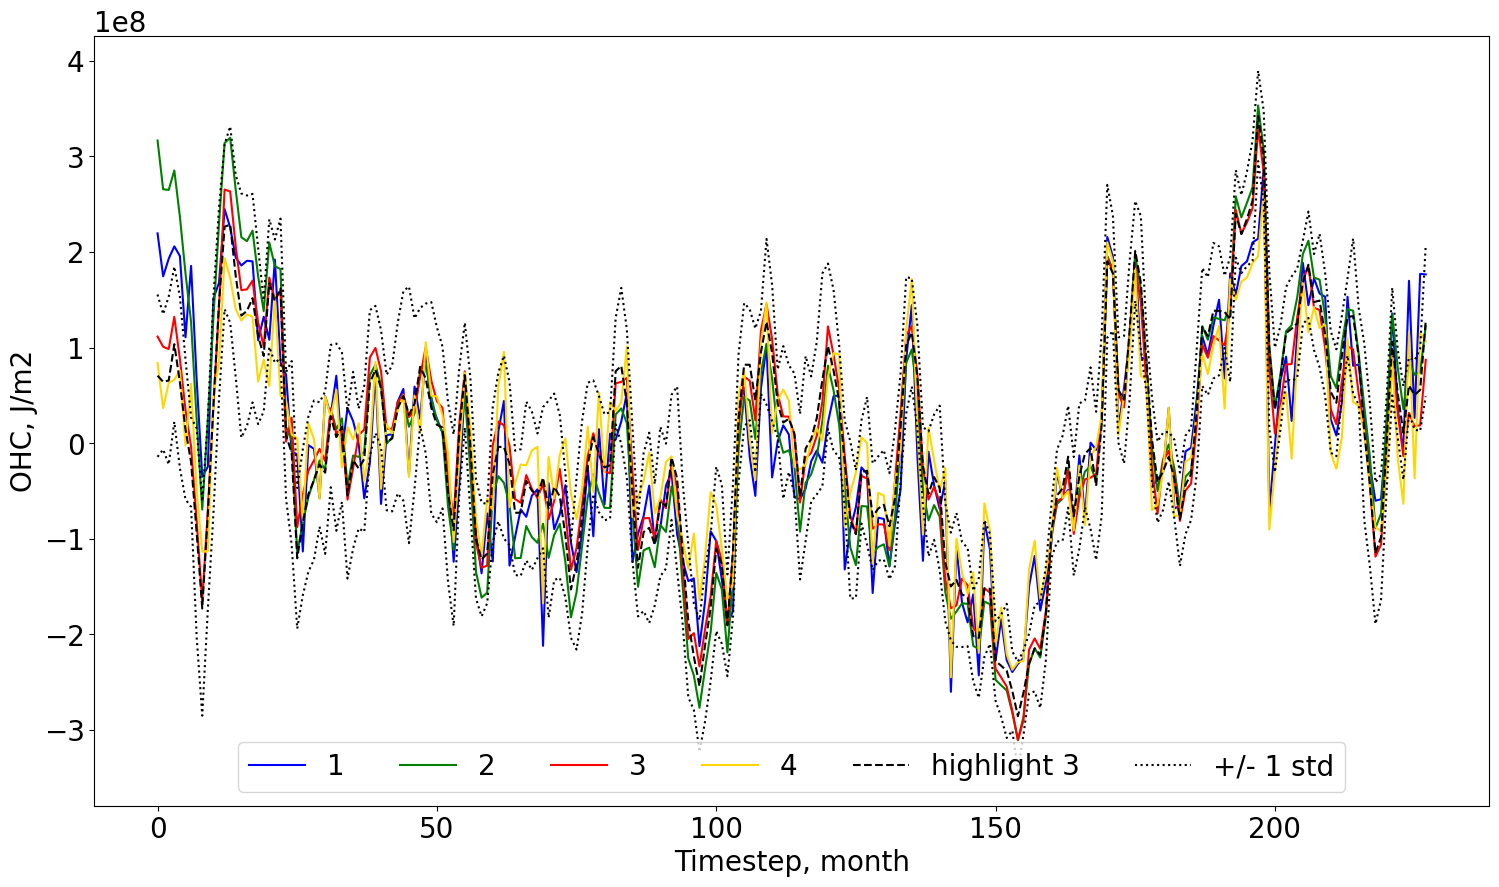

In [13]:
# redo the same anomaly plot, now after removing the trend and including errorbars for one method: how would the plot look like if you used fewer conditional simulations?
plt.figure(figsize=(18, 10))
plt.rc('font', size=20)

for i,i_ds in enumerate(ds.keys()):
    d_1d = xarray_regional_mean(ds[i_ds], form='area').DATA.groupby('TIME.month').apply(remove_time_mean).to_dataset().apply(detrend).DATA
    
    plt.plot(d_1d,color=cols[i])

d_1d = xarray_regional_mean(ds['dataset'+str(tag_method_with_CondSim)], form='area').apply(detrend).DATA.groupby('TIME.month').apply(remove_time_mean)

d_1d_CondSim = xarray_regional_mean(ds_CondSim['dataset'+str(tag_method_with_CondSim)], form='area').apply(detrend).DATA.groupby('TIME.month').apply(remove_time_mean)

plt.plot(d_1d,color='k',linestyle='--')
plt.plot(d_1d-d_1d_CondSim.std(dim='record'),color='k',linestyle=':')
plt.plot(d_1d+d_1d_CondSim.std(dim='record'),color='k',linestyle=':')

tag_datasets_all = copy.deepcopy(tag_datasets)
tag_datasets_all.append('highlight '+str(tag_method_with_CondSim))
tag_datasets_all.append( '+/- 1 std')

plt.legend(tag_datasets_all,ncol=len(tag_datasets_all),loc='lower center')
plt.xlabel('Timestep, month')
plt.ylabel('OHC, J/m2')
plt.show()

In [14]:
xarray_regional_mean(ds[i_ds], form='area').DATA.groupby('TIME.month').apply(remove_time_mean).to_dataset()

<xarray.Dataset> Size: 4kB
Dimensions:  (TIME: 228)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2022-12-15
Data variables:
    DATA     (TIME) float64 2kB -3.993e+08 -4.421e+08 ... 5.942e+08 5.895e+08

In [15]:
xarray_regional_mean(ds[i_ds], form='area')

<xarray.Dataset> Size: 4kB
Dimensions:  (TIME: 228)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2022-12-15
Data variables:
    DATA     (TIME) float64 2kB 1.107e+12 1.107e+12 ... 1.108e+12 1.108e+12

### Question #2: Create plots for a few quantities of interest to you (some examples are provided in the Learning Goals section above, yet please explore what is of interest to you!), including errorbars based on conditional simulations when available (i.e. use the standard deviation of the quantity of interest across different conditional simulation fields as in the example just above; conditional simulations are only available for method 3, in this example). Do your errorbars change if you include fewer conditional simulations? 

Hint: you can restrict the number of files loaded from nc/CondSim (to reduce the number of conditional simulations used) either editing the loading command above or creating a subfolder in nc/CondSim to remove some of the files from the main nc/CondSim folder.